# Notebook pour tester le bibliothèque Detectron 2 

### Installation et imports

In [7]:
! python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-61nz_84r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-61nz_84r
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


##### Vérification des installations principales

In [8]:
import torch, detectron2, cv2

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
print('cv2', cv2.__version__)

torch:  2.5 ; cuda:  cu124
detectron2: 0.6
cv2 4.10.0


##### Quelques modules à importer 

1. setup_logger = charger les logs de l'entrainement
2. model_zoo = module qui importe plein de modèle et de masks pré-entrainés
3. DefaultPredictor = modèle pré-entrainé qui permet de faire de la segmentation d'instance
4. get_cfg = permet de faire la config a instancier dans DefaultPredictor
5. Visualizer = afficher les images 
6. MetadataCatalog, DatasetCatalog = gérer et utiliser les métadonnées d'un dataset/dataset

In [9]:

from detectron2.utils.logger import setup_logger
setup_logger(color=True)

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


#### Format COCO (Common Object in Context)

Le format COCO (Common Objects in Context) est un format de données largement utilisé pour les tâches de détection d'objets, de segmentation d'instance, et de reconnaissance de poses dans le domaine de la vision par ordinateur. Ce format a été développé principalement dans le cadre du challenge COCO (COCO Challenge), qui est un des benchmarks de référence dans le domaine.

In [10]:
from detectron2.data.datasets import register_coco_instances
# dataset -- validation
register_coco_instances("food/train_data", {},
                        "../raw_data/public_training_set_release_2.0/annotations.json",
                        "../raw_data/public_training_set_release_2.0/images")

# dataset -- validation
register_coco_instances("food/val_data", {},
                        "../raw_data/public_validation_set_2.0/annotations.json",
                        "../raw_data/public_validation_set_2.0/images")

In [11]:
train_metadata = MetadataCatalog.get('food/train_data')
train = DatasetCatalog.get('food/train_data')

[11/27 16:43:19 d2.data.datasets.coco]: Loading ../raw_data/public_training_set_release_2.0/annotations.json takes 2.57 seconds.
WARNING [11/27 16:43:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/27 16:43:19 d2.data.datasets.coco]: Loaded 39962 images in COCO format from ../raw_data/public_training_set_release_2.0/annotations.json


In [12]:
train[8]

{'file_name': '../raw_data/public_training_set_release_2.0/images/006483.jpg',
 'height': 426,
 'width': 426,
 'image_id': 6483,
 'annotations': [{'iscrowd': 0,
   'bbox': [151.76250000000002,
    151.76250000000002,
    161.87999999999997,
    212.99999999999997],
   'category_id': 286,
   'segmentation': [[262.5225,
     157.62,
     182.6475,
     181.04999999999998,
     185.8425,
     202.35,
     151.76250000000002,
     223.65,
     170.9325,
     247.07999999999998,
     301.9275,
     283.29,
     313.6425,
     241.755,
     331.7475,
     235.365,
     332.8125,
     207.67499999999998,
     364.7625,
     221.52,
     357.3075,
     202.35,
     321.0975,
     170.4,
     261.4575,
     155.49]],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [56.977500000000006, 43.1325, 193.82999999999998, 207.675],
   'category_id': 73,
   'segmentation': [[56.977500000000006,
     172.53,
     249.7425,
     156.555,
     250.8075,
     120.34499999999998,
     214.

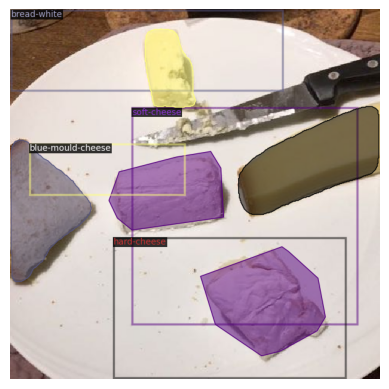

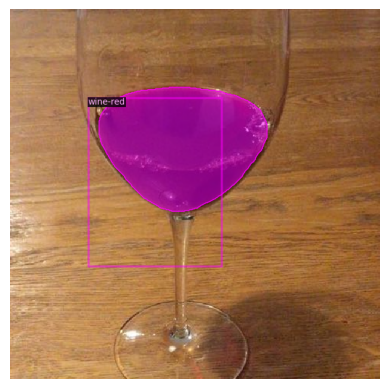

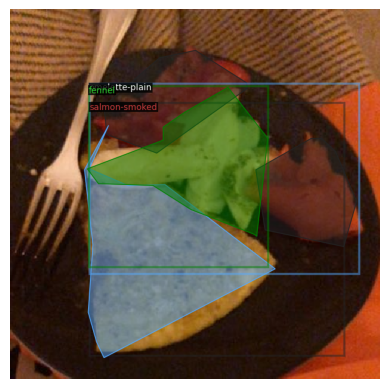

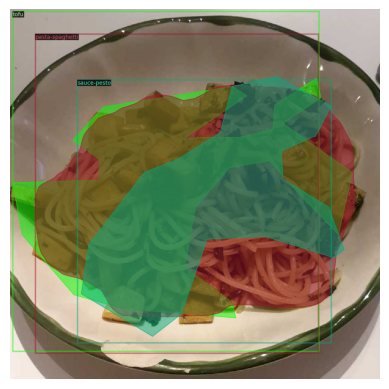

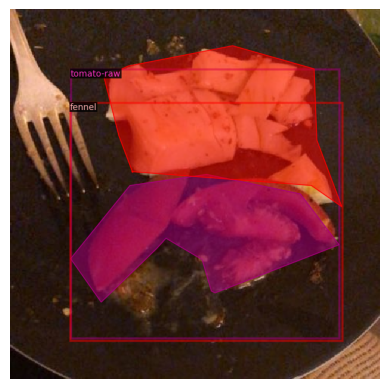

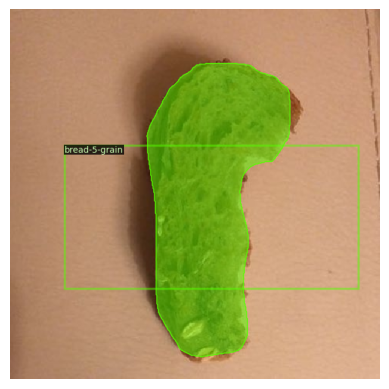

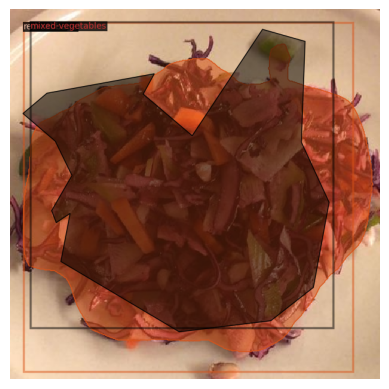

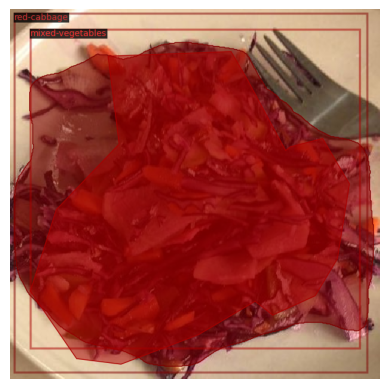

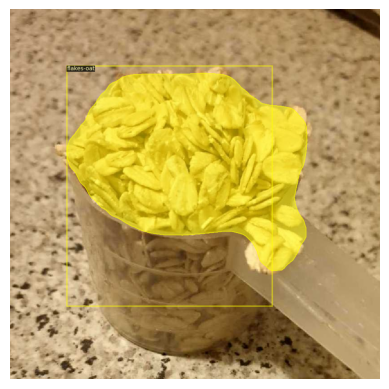

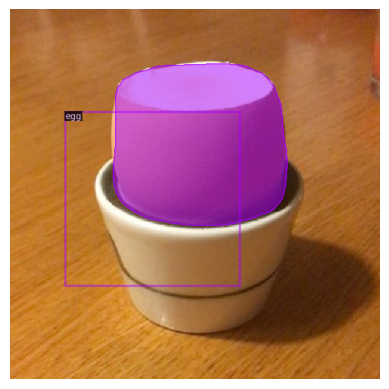

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

for d in train[3476: 3486]:
    img = Image.open(d['file_name'])
    visualizer = Visualizer(img, scale=1.25, metadata=train_metadata)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.show()

In [14]:
from detectron2.engine import DefaultTrainer
checkpoint = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(checkpoint))
cfg.DATASETS.TRAIN = ("food/train_data", )
cfg.DATASETS.VAL = ("food/val_data", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint)
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 512
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 2.31 MiB is free. Process 23937 has 5.40 GiB memory in use. Including non-PyTorch memory, this process has 354.00 MiB memory in use. Of the allocated memory 259.49 MiB is allocated by PyTorch, and 14.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0
predictor = DefaultPredictor(cfg)

[11/26 16:33:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return tor

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("food/val_data", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "food/val_data")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [11/26 16:34:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/26 16:34:24 d2.data.datasets.coco]: Loaded 1000 images in COCO format from ../raw_data/public_validation_set_2.0/annotations.json
[11/26 16:34:24 d2.data.build]: Distribution of instances among all 498 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| beetroot-st.. | 5            | carrot-stea.. | 2            | mushroom-av.. | 2            |
| savoy-cabba.. | 0            | zucchini-st.. | 0            | vanille-cre.. | 0            |
| shrimp-boiled | 3            | spinach-ste.. | 2            |  spinach-raw  | 2            |
| green-bean-.. | 1            | sweet-corn-.. | 2            | watermelon-.. | 5            |
| pizza-with-.. | 1            | pizza-with-.. | 1            | pizza-with

In [ ]:
path_dir = '../raw_data/public_test_release_2.0/images/'
img = Image.open(path_dir)
img = np.array(img)
img

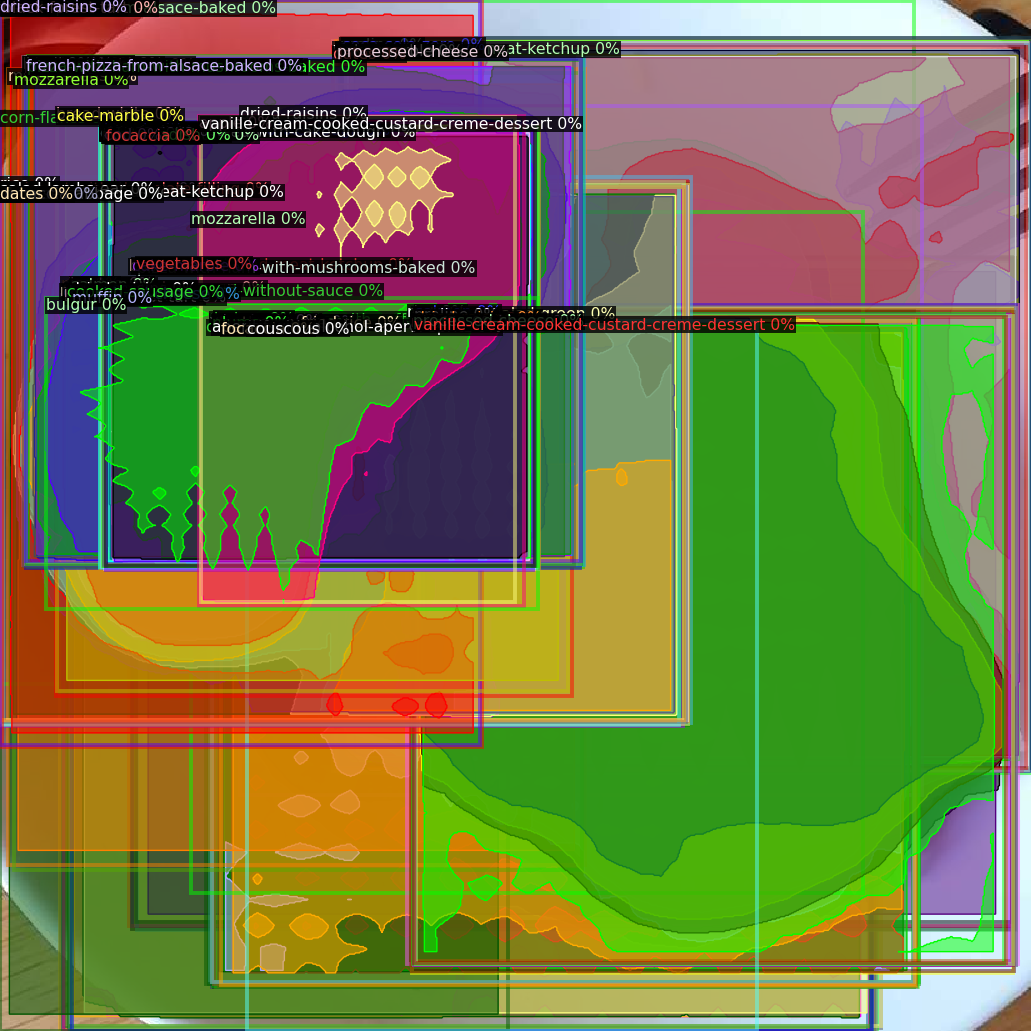

: 

In [22]:
from PIL import Image

path = '../raw_data/public_test_release_2.0/images/012030.jpg'
img = Image.open(path)
img = np.array(img)
outputs=predictor(img)
visualizer = Visualizer(img, scale=1.25, metadata=train_metadata)
v = visualizer.draw_instance_predictions(outputs['instances'].to("cpu"))
img_with_boxes = Image.fromarray(v.get_image())
img_with_boxes